# 01. Exploring the impact of cyclones on vegetation: scene before and after cyclone

metadata blah

In [2]:
#Import libraries 

%pylab notebook
# from __future__ import print_function
import pandas as pd
import xarray as xr
from datetime import date, timedelta
import gdal
from gdal import *

import datacube
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube_stats.statistics import GeoMedian

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets
import rasterio
import seaborn as sns
sns.set(color_codes=True)

dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

Populating the interactive namespace from numpy and matplotlib


# User requirement: specify directory locations

In [3]:
###User input: enter the directory location of input data. Ensure "/" are used, not "\"
input_folder = '/g/data/w85/ext547/input_data/'

###User input: enter the directory location of output data. Please enter again if the same as input_folder. Ensure "/" are used, not "\"
output_folder = '/g/data/w85/ext547/cyclone_repo/output_data/'

# User requirement: specifiy location of interest and details about cyclone

In [4]:
###User input: enter area of interest

lat_min = -20.267 #down
lat_max = -20.216 #up
lon_min = 148.534 #left
lon_max = 148.592 #right

#High Mt QLD
# lat_min = -20.375 #down
# lat_max = -20.340 #up
# lon_min = 148.757 #left
# lon_max = 148.806 #right

# lat_min = -20.385 #down
# lat_max = -20.326 #up
# lon_min = 148.916 #left
# lon_max = 148.984 #right

##User input: enter the name of vegetation of interest, e.g. "forest" or "banana crop"
vegetation_type = 'forest'

##User input: enter the name of the area/region/place/location of interest, e.g. "Hamilton Island"
location_name = 'Mt Dryander QLD'

###User input: enter start and end date of cyclone
start_of_event= '2017-03-23'
end_of_event= '2017-04-07'

###User input: enter the name of cyclone
cyclone_name =  'Debbie'

###User input: set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene. Scenes will not be retrieved that have less than the cloud threshold worth of image.
#The default value is "0.90" or >90% image and <10% cloud cover
cloud_free_threshold = 0.80 

# Datacube query is completed

In [5]:
#Temporal range, wavelengths/band and sensors of interest are defined

#temporal range is defined
start_of_epoch = '2000-01-01'
end_of_epoch =  '2017-12-31'

# #wavelengths/bands of interest are defined
# bands_of_interest = [#'blue',
#                      'green',
#                      'red', 
#                      'nir',
#                      'swir1', 
#                      #'swir2'
                     ]

#Landsat sensors of interest are defined
sensors = ['ls8', 
    'ls7',
    'ls5'] 

#query is created
query = {'time': (start_of_epoch, end_of_epoch),}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print(query)

{'time': ('2000-01-01', '2017-12-31'), 'x': (148.534, 148.592), 'y': (-20.216, -20.267), 'crs': 'EPSG:4326'}


In [6]:
#Reformat variables

start_of_event=datetime.datetime.strptime(start_of_event,'%Y-%m-%d') #Convert to datetime
end_of_event=datetime.datetime.strptime(end_of_event,'%Y-%m-%d') #Convert to datetime
location_name=location_name.replace(" ","_") #replace spaces with underscore

# Data is extracted from Open Datacube

The extracted data is first filtered using the criteria in "mask_components". 
The cloudiness of the scenes is then tested, and any scenes that do not meet the given "cloud_free_threshold" are discarded.
Additionally, any pixel that is located within the ocean/sea will be converted to "nan" values with the 'land_sea' command.

In [7]:
#Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results. It should be noted the "land_sea" code will remove all ocean/sea pixels.

mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True,
'land_sea': 'land'}

In [65]:
sensor_fc = dc.load(product= 'ls7_fc_albers', group_by='solar_day', **query)
sensor_pq = dc.load('ls7_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **query)
print (sensor_fc.time)
print (sensor_pq.time)

crs = sensor_fc.crs
crswkt = sensor_fc.crs.wkt
affine = sensor_fc.affine

# sensor_fc = sensor_fc.sel(time = sensor_pq.time, drop=True)
# print(sensor_fc)

<xarray.DataArray 'time' (time: 327)>
array(['2000-01-06T23:57:40.500000000', '2000-01-22T23:57:38.500000000',
       '2000-03-10T23:57:24.500000000', ..., '2017-08-01T00:07:28.500000000',
       '2017-08-17T00:07:26.500000000', '2017-09-18T00:07:24.500000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-06T23:57:40.500000 ...
Attributes:
    units:    seconds since 1970-01-01 00:00:00
<xarray.DataArray 'time' (time: 328)>
array(['2000-01-06T23:57:40.500000000', '2000-01-22T23:57:38.500000000',
       '2000-03-10T23:57:24.500000000', ..., '2017-08-17T00:07:26.500000000',
       '2017-09-18T00:07:24.500000000', '2017-10-20T00:07:28.500000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-06T23:57:40.500000 ...
Attributes:
    units:    seconds since 1970-01-01 00:00:00


In [ ]:
    sensor_pq = dc.load('ls8_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **query)

In [52]:
#Data for each Landsat sensor is retrieved

sensor_clean = {}

for sensor in sensors:
    #Load the FC and corresponding PQ
    sensor_fc = dc.load(product= sensor+'_fc_albers', group_by='solar_day', **query)
#     sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
#                         fuse_func=ga_pq_fuser, **query)
    
    #Retrieve the projection information before masking/sorting
    crs = sensor_fc.crs
    crswkt = sensor_fc.crs.wkt
    affine = sensor_fc.affine
    
#     #Ensure there's PQ to go with the FC
#     sensor_fc = sensor_fc.sel(time = sensor_pq.time, drop=True)
    
#     #Apply the PQ masks to the FC
#     quality_mask = masking.make_mask(sensor_pq, **mask_components)
#     good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
#     sensor_fc2 = sensor_fc.where(good_data)
    
#     #Calculate the percentage cloud free for each scene
#     cloud_free = masking.make_mask(sensor_fc, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
#                                    contiguous=True).pixelquality
#     mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
        
#     #Discard data that does not meet the cloud_free_threshold
#     mostly_good = sensor_fc2.where(mostly_cloud_free).dropna(dim='time', how='all')
#     mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
#     sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

loaded ls8
loaded ls7
loaded ls5
complete


In [66]:
nbar_clean= sensor_fc

In [36]:
# #Data for each Landsat sensor is retrieved

# sensor_clean = {}

# for sensor in sensors:
#     #Load the NBAR and corresponding PQ
#     sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
#                           measurements = bands_of_interest,  **query)
#     sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
#                         fuse_func=ga_pq_fuser, **query)
    
#     #Retrieve the projection information before masking/sorting
#     crs = sensor_nbar.crs
#     crswkt = sensor_nbar.crs.wkt
#     affine = sensor_nbar.affine
    
#     #Ensure there's PQ to go with the NBAR
#     sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
#     #Apply the PQ masks to the NBAR
#     quality_mask = masking.make_mask(sensor_pq, **mask_components)
#     good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
#     sensor_nbar2 = sensor_nbar.where(good_data)
    
#     #Calculate the percentage cloud free for each scene
#     cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
#                                    contiguous=True).pixelquality
#     mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
        
#     #Discard data that does not meet the cloud_free_threshold
#     mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
#     mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
#     sensor_clean[sensor] = mostly_good

#     print('loaded %s' % sensor) 
    

# print ('complete')

In [40]:
#Check the output

sensor_clean

{}

In [54]:
#Data from different sensors are joined together and sorted so that observations are sorted by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), 'time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

ValueError: must supply at least one object to concatenate

In [67]:
#Check that the concatenation worked

nbar_clean

<xarray.Dataset>
Dimensions:  (time: 327, x: 269, y: 257)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-06T23:57:40.500000 ...
  * y        (y) float64 -2.279e+06 -2.279e+06 -2.279e+06 -2.279e+06 ...
  * x        (x) float64 1.714e+06 1.714e+06 1.714e+06 1.714e+06 1.714e+06 ...
Data variables:
    BS       (time, y, x) int8 1 0 9 0 0 10 8 9 7 0 2 0 1 2 12 0 6 15 19 44 ...
    PV       (time, y, x) int8 85 84 91 100 100 88 92 88 93 99 83 97 90 77 ...
    NPV      (time, y, x) int8 12 14 0 0 0 2 0 2 0 0 13 2 8 21 15 18 19 11 0 ...
    UE       (time, y, x) int8 20 23 31 32 36 37 37 34 33 28 22 22 22 23 23 ...
Attributes:
    crs:      EPSG:3577

# Find the scenes that occur before and after cyclone

In [73]:
#Retun time and sensor information
product_time = nbar_clean[['time']].to_dataframe() #Add time and product to dataframe
product_time.index = product_time.index + pd.Timedelta(hours=10) #Roughly convert to local time
product_time.index = product_time.index.map(lambda t: t.strftime('%Y-%m-%d')) #Remove Hours/Minutes Seconds by formatting into a string

In [74]:
#Save cyclone "event" date in correct format for plotting
event_dates=pd.DataFrame()
delta = end_of_event - start_of_event
for i in range(delta.days + 1):
    date=start_of_event + timedelta(days=i)
    date=pd.DataFrame([date],index=None)
    event_dates=event_dates.append(date)
event_dates.columns=['date']
event_dates=event_dates.set_index('date',drop=False)
event_dates.index=event_dates.index.map(lambda t: t.strftime('%Y-%m-%d'))
event_dates['value']=1

In [75]:
#Save "interest dates" in correct format for plotting. Interest dates are set to help visulise avaliable scenes on either side of the cyclone.
start_of_interest= start_of_event+datetime.timedelta(days=-200) #default of 200 days
end_of_interest= end_of_event+datetime.timedelta(days=200) #default of 200 days

interest_dates=pd.DataFrame()
delta = end_of_interest - start_of_interest
for i in range(delta.days + 1):
    date=start_of_interest + timedelta(days=i)
    date=pd.DataFrame([date],index=None)
    interest_dates=interest_dates.append(date)

interest_dates.columns=['date']
interest_dates=interest_dates.set_index('date',drop=False)
interest_dates.index=interest_dates.index.map(lambda t: t.strftime('%Y-%m-%d'))
interest_dates['value']=1

In [76]:
#Merge dates of interest with the Landsat scenes to match dates
subset_data = pd.merge(interest_dates, product_time, left_index=True,#left_on= 'date', 
                       right_index=True, how='inner') #Match dates and merge

In [77]:
product_time

""
time
2000-01-07
2000-01-23
2000-03-11
2000-03-27
2000-04-12
2000-05-14
2000-05-30
2000-07-01
2000-07-17


# Create an interactive graph that shows suitable imagery before and after the cyclone

<IPython.core.display.Javascript object>


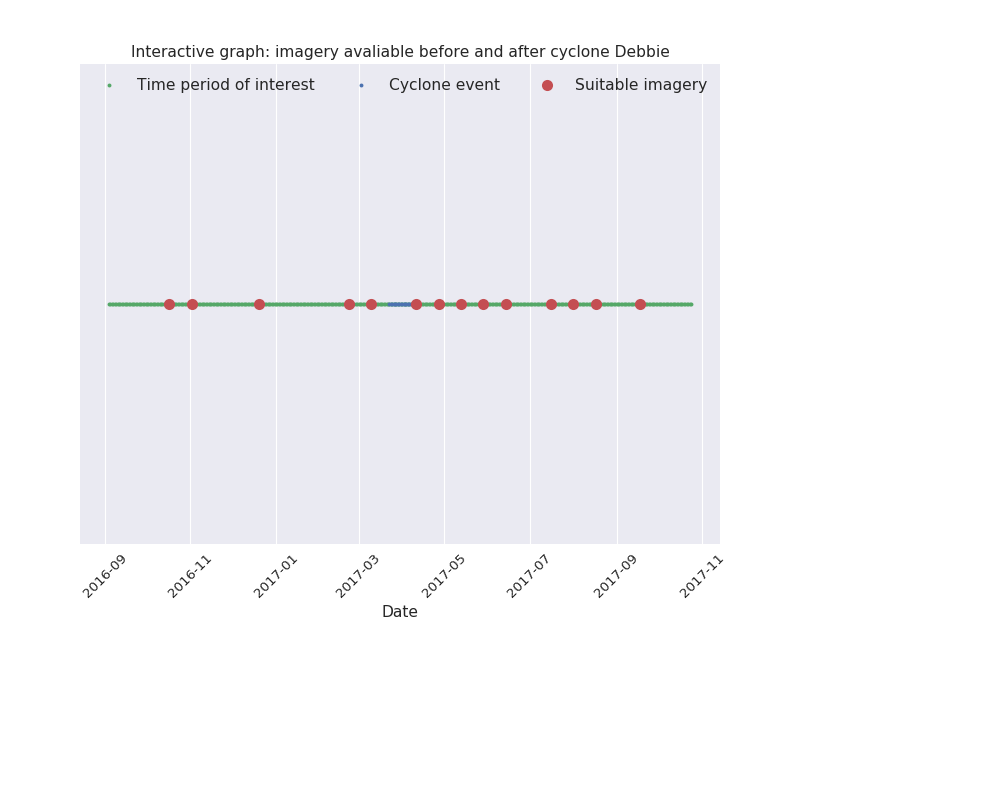

HTML(value='Event information appears here when you click on the figure')

In [78]:
#Create interactive plot that enables the user to select a scene. User should select a scene before the cyclone event

#create widget that enables interaction with plot
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global date_int, devent
    devent = event
    date_int = event.xdata
    time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

#Set up plot
fig = plt.figure(figsize=(10,8)) #Set plot size
fig.canvas.mpl_connect('button_press_event', callback) #Plot setup
plt.title('Interactive graph: imagery avaliable before and after cyclone ' +str(cyclone_name), size=14) #Plot title
display(w) #Plot setup with interactive widget
plt.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.15) #Set border dimensions
fig.patch.set_facecolor('white') #Make border is white
fig.patch.set_alpha(0.99) #Ensure border is white

#Plot dates of interest, dates of cyclone and dates of imagery
plt.plot_date(interest_dates.date,interest_dates.value, 'g.', 
                            label= 'Time period of interest')
plt.plot_date(event_dates.date,event_dates.value, 'b.', 
                            label= 'Cyclone event')
plt.plot_date(subset_data.date,subset_data.value, 'r.', markersize=20,
                            label= 'Suitable imagery') #the term "suitable" is defined by cloud_free_threshold.
#Axis details
plt.yticks([]) #remove y axis values as not required
plt.xticks(rotation=45,size=12) #Rotate and format size of date labels
plt.xlabel('Date', size=14) #Set X label
plt.legend(edgecolor ='none', ncol=3, loc=9, fontsize=14) #Set legend location on plot

plt.show() #Plot setup

In [94]:
#Save figure
plt.savefig(str(output_folder)+'imagery_avaliable_cyclone_'+str(cyclone_name)+'_'+str(location_name))

In [95]:
#reformat and show date clicked on interactive graph
time_slice = matplotlib.dates.num2date(date_int).date()
# time_slice= np.datetime64(time_slice)
subset_data['date'] = pd.to_datetime(subset_data['date'], format='%Y-%m-%d')
subset_data['difference']=(subset_data['date'] - time_slice).abs() 
time_slice=subset_data.iloc[argsort(subset_data['difference'])].date
time_slice= (list(time_slice)[0])
time_slice_str=datetime.datetime.strftime(time_slice,'%Y-%m-%d')
time_slice

Timestamp('2017-02-22 00:00:00')

In [100]:
rgb = nbar_clean.sel(time =time_slice, method = 'nearest').to_array(dim='color').sel(color=[
    'BS','PV', 'NPV']).transpose('y', 'x', 'color')

In [101]:
rgb

<xarray.DataArray (y: 257, x: 269, color: 3)>
array([[[ 40,  56,   0],
        [ 37,  59,   0],
        ..., 
        [  2,  88,   8],
        [  6,  86,   7]],

       [[ 38,  58,   0],
        [ 37,  59,   0],
        ..., 
        [  0,  94,   5],
        [  1,  91,   7]],

       ..., 
       [[ 45,  55,   0],
        [ 39,  55,   5],
        ..., 
        [  0,  98,   0],
        [  0, 100,   0]],

       [[ 43,  57,   0],
        [ 43,  57,   0],
        ..., 
        [  0,  99,   0],
        [  0, 100,   0]]], dtype=int8)
Coordinates:
    time     datetime64[ns] 2017-02-22T00:06:51.500000
  * y        (y) float64 -2.279e+06 -2.279e+06 -2.279e+06 -2.279e+06 ...
  * x        (x) float64 1.714e+06 1.714e+06 1.714e+06 1.714e+06 1.714e+06 ...
  * color    (color) <U3 'BS' 'PV' 'NPV'
Attributes:
    crs:      EPSG:3577

<IPython.core.display.Javascript object>


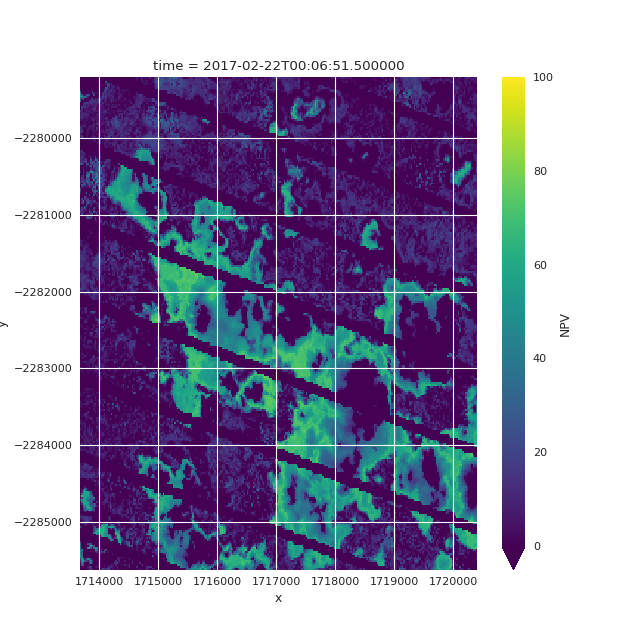

In [99]:
fig = plt.figure(figsize =(8,8))
rgb.NPV.plot.imshow(vmin = 0, vmax = 100)
plt.show() #Create image

In [81]:
#Prepare imagery
rgb = nbar_clean.sel(time =time_slice, method = 'nearest').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

KeyError: "not all values found in index 'color'"

<IPython.core.display.Javascript object>


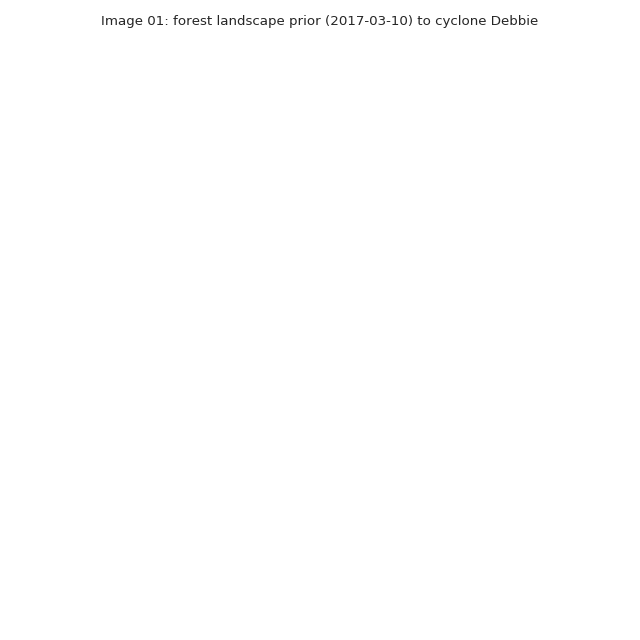

TypeError: Image data cannot be converted to float

In [82]:
#Create image that shows landscape before cyclone

fig = plt.figure(figsize =(8,8)) #Edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions
fig.patch.set_facecolor('white') #Make border white 
fig.patch.set_alpha(0.99)#Ensure border white
plt.axis('off')#remove axis 
plt.title('Image 01: ' + str(vegetation_type)+ ' landscape prior (' +time_slice_str+ ') to cyclone '+ str(cyclone_name)) #add title
plt.imshow(nbar_clean, interpolation = 'nearest') #create image
plt.show() #show image

In [ ]:
#Save figure
plt.savefig(str(output_folder)+'landscape_image01_'+str(cyclone_name)+'_'+str(location_name)+'_'+time_slice_str)

In [ ]:
#Calculate NDVI
ndvi = ((nbar_clean.nir-nbar_clean.red)/(nbar_clean.nir+nbar_clean.red))
ndvi_of_interest= ndvi.sel(time = time_slice, method='nearest') #select scene

ndvi.attrs['crs'] = crs
ndvi.attrs['affine'] = affine

In [ ]:
#Plot NDVI for scene prior to cyclone

#Controls for NDVI colour map
ndvi_cmap = mpl.colors.ListedColormap(['blue', 'red', 'orange', '#ffcc66','#ffffcc' , '#ccff66' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.5, 0.8, 0.9, 0.95, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

#Create plot
fig = plt.figure(figsize =(8,8)) #Edit size of plot 
plt.axis('off')#remove axis 
fig.patch.set_facecolor('white') #Make border white
fig.patch.set_alpha(0.99)#Ensure border white
plt.title('NDVI 01: ' + str(vegetation_type)+ ' landscape prior (' +time_slice_str+ ') to cyclone '+ str(cyclone_name)) #add title
i=plt.imshow(ndvi_of_interest,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm) #create image with colourbar
fig.colorbar(i) #add colour bar

In [ ]:
#Save figure
plt.savefig(str(output_folder)+'NDVI01_'+str(cyclone_name)+'_'+str(location_name)+'_'+time_slice_str)

# Landscape and NDVI of scene after cyclone

In [ ]:
#Create interactive plot that enables the user to select a scene. User should select a scene after the cyclone event

#create widget that enables interaction with plot
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global date_int2, devent
    devent = event
    date_int2 = event.xdata
    time_int_ = time_int2.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

#Set up plot
fig = plt.figure(figsize=(10,8)) #Set plot size
fig.canvas.mpl_connect('button_press_event', callback) #Plot setup
plt.title('Interactive graph: imagery avaliable before and after cyclone ' +str(cyclone_name), size=14) #Plot title
display(w) #Plot setup with interactive widget
plt.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.15) #Set border dimensions
fig.patch.set_facecolor('white') #Make border is white
fig.patch.set_alpha(0.99) #Ensure border is white

#Plot dates of interest, dates of cyclone and dates of imagery
plt.plot_date(interest_dates.date,interest_dates.value, 'g.', 
                            label= 'Time period of interest')
plt.plot_date(event_dates.date,event_dates.value, 'b.', 
                            label= 'Cyclone event')
plt.plot_date(subset_data.date,subset_data.value, 'r.', markersize=20,
                            label= 'Suitable imagery') #the term "suitable" is defined by cloud_free_threshold.
#Axis details
plt.yticks([]) #remove y axis values as not required
plt.xticks(rotation=45,size=12) #Rotate and format size of date labels
plt.xlabel('Date', size=14) #Set X label
plt.legend(edgecolor ='none', ncol=3, loc=9, fontsize=14) #Set legend location on plot

plt.show() #Plot setup

In [ ]:
#reformat and show date clicked on interactive graph
time_slice02 = matplotlib.dates.num2date(date_int2).date()
subset_data['date'] = pd.to_datetime(subset_data['date'], format='%Y-%m-%d')
subset_data['difference']=(subset_data['date'] - time_slice02).abs() 
time_slice02=subset_data.iloc[argsort(subset_data['difference'])].date
time_slice02= (list(time_slice02)[0])
time_slice02_str=datetime.datetime.strftime(time_slice02,'%Y-%m-%d')
time_slice02

In [ ]:
#Prepare imagery for scene after cyclone

rgb02 = nbar_clean.sel(time =time_slice02, method = 'nearest').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb02 = rgb02.astype('double')
clipped_visible02 = rgb02.where(rgb02<fake_saturation).fillna(fake_saturation)
max_val02 = clipped_visible02.max(['y', 'x'])
scaled02 = (clipped_visible02 / max_val02)

In [ ]:
#Create image that shows landscape after cyclone

fig = plt.figure(figsize =(8,8)) #Edit size of plot
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions
fig.patch.set_facecolor('white') #Make border white
fig.patch.set_alpha(0.99)#Ensure border white
plt.axis('off')#remove axis
plt.title('Image 02: ' + str(vegetation_type)+ ' landscape after ('+time_slice02_str+ ') cyclone '+ str(cyclone_name)) #add title
plt.imshow(scaled02, interpolation = 'nearest') #create image
plt.show() #show image

In [ ]:
#Save figure
plt.savefig(str(output_folder)+'landscape_image02_'+str(cyclone_name)+'_'+str(location_name)+'_'+time_slice_str) 

In [ ]:
#Select NDVI for scene after cyclone
ndvi_of_interest02= ndvi.sel(time = time_slice02, method='nearest')
ndvi_of_interest02

In [ ]:
#Plot NDVI for scene after cyclone

fig = plt.figure(figsize =(8,8)) #Edit size of plot 
plt.axis('off')#remove axis 
fig.patch.set_facecolor('white') #Make border white
fig.patch.set_alpha(0.99)#Ensure border white
plt.title('NDVI 02: ' + str(vegetation_type)+ ' landscape after (' +time_slice_str+ ') cyclone '+ str(cyclone_name)) #add title
i=plt.imshow(ndvi_of_interest02,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm) #create image with colourbar
fig.colorbar(i) #add colour bar

In [ ]:
#Save figure
plt.savefig(str(output_folder)+'NDVI02_'+str(cyclone_name)+'_'+str(location_name)+'_'+time_slice_str)

# Change in vegetation before/after cyclone

In [ ]:
#Calculate the difference in NDVI from before to after cyclone

ndvi_change= ndvi_of_interest02-ndvi_of_interest
ndvi_change.attrs['affine'] = affine

In [ ]:
#Plot the change of NDVI
fig = plt.figure(figsize=(10,8)) #create plot
ndvi_change.plot(cmap = 'RdYlGn',vmin=-1,vmax=1) #create image
plt.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.10) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.title('NDVI difference for '+str(vegetation_type)+ ' landscape before and after Cyclone '+str(cyclone_name)) #add title
plt.axis('off')#remove axis
plt.show() #show image

In [ ]:
#Save figure
plt.savefig(str(output_folder)+'NDVI_change_'+str(cyclone_name)+'_'+str(location_name))

# Import and process windfield data to ensure pixel size and projection is the same as NDVI dataset

In [ ]:
#read windfield geotiff
windfield = gdal.Open(input_folder+'Final_corrected_TCDebbie_wind.tif', gdal.GA_ReadOnly)
windfield

In [ ]:
#get projection information from windfiled
windfield_proj = windfield.GetProjection()
windfield_proj

In [ ]:
#Convert NDVI data array to raster saved in memory

#save NDVI_change dataset to a numpy array
ndvi_array = np.asarray(ndvi_change)

#define conversion variables
cols= int(ndvi_change.x.count())
rows= int(ndvi_change.y.count())
originX= ndvi_change.affine.c
dx= ndvi_change.affine.a
originY= ndvi_change.affine.f
dy= ndvi_change.affine.e
epsg=int((str(crs)).replace('EPSG:',''))
nodata=0

#complete conversion of NDVI array into raster
driver = gdal.GetDriverByName('MEM')
ndvi_raster = driver.Create('ndvi', cols, rows, 1, gdal.GDT_Float32)
ndvi_raster.SetGeoTransform((originX, dx, 0, originY, 0, dy))
ndvi_band = ndvi_raster.GetRasterBand(1)
ndvi_band.WriteArray(ndvi_array)
ndvi_band.SetNoDataValue(nodata)
ndvi_raster_SRS = osr.SpatialReference()
ndvi_raster_SRS.ImportFromEPSG(epsg)
ndvi_raster.SetProjection(ndvi_raster_SRS.ExportToWkt())
ndvi_band.FlushCache()

In [ ]:
#Save metadata from NDVI_change
match_ds = ndvi_raster
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

In [ ]:
#Create a  geotiff that is the same size and is in the same projection as the NDVI dataset
drv = gdal.GetDriverByName('GTiff')
windfield_matched = drv.Create('ouput_file', wide, high, 1, gdal.GDT_Float32)
windfield_matched.SetGeoTransform(match_geotrans)
windfield_matched.SetProjection(match_proj)

#create windfield geotiff
resampling_method = gdalconst.GRA_Bilinear
gdal.ReprojectImage(windfield, windfield_matched, windfield_proj, match_proj, resampling_method)

#view datasets and projections to ensure information looks correct
print ('windfield       = ', windfield)
print ('windfield_matched             = ',windfield_matched)
print ('windfield_proj        = ',windfield_proj)
print ('match_proj      = ',match_proj)

# Save resampled windfield as an array and check array shape

In [ ]:
windfield_matched_array=windfield_matched.ReadAsArray()

print('windfield shape = '+ str(shape(windfield_matched_array)))
print('ndvi_change shape = '+ str(shape(ndvi_change.values)))

In [ ]:
windfield_matched_array

In [ ]:
ndvi_change

# Create a plot that examines relationship between wind and change in NDVI after a cyclone

In [ ]:
#set variables to allow automatic X-axis on plot
x_min=np.around(np.amin(windfield_matched_array),decimals=-1)-10
x_max=np.around(np.amax(windfield_matched_array),decimals=-1)+10
x_num= np.around(np.amax(windfield_matched_array)-np.amin(windfield_matched_array))

In [ ]:
coords_da={'y': ndvi_change.y, 'x': ndvi_change.x}
windfield_da = xr.DataArray(windfield_matched_array, dims=('y','x'), coords=coords_da)
dataset = xr.Dataset({'ndvi_dataset': ndvi_change, 'windfield_dataset': windfield_da})

i=dataset.groupby_bins(dataset.windfield_dataset,bins=x_num,include_lowest=True)
blah=i.mean()
blah

In [ ]:
#create plot that compares change in NDVI and windfield values
fig = plt.figure(figsize=(10,6))
plt.plot(windfield_matched_array, ndvi_change.values, 'o', markeredgecolor='red', markeredgewidth=0.5, markerfacecolor='None') 
plot(blah.windfield_dataset,blah.ndvi_dataset, 'k')

plt.axis([x_min , x_max ,-1.0, 1.0], 'tight')
plt.xlabel('Modelled wind field (m s$^{-1}$)') #Set X label
plt.ylabel('Change in NDVI before and after cyclone '+str(cyclone_name)) #Set Y label
plt.plot([x_min, x_max], [0,0], 'k-', lw=1) #add blackline at 0 to plot
fig.patch.set_facecolor('white') #Make background white
fig.patch.set_alpha(0.99)#Make border white
plt.show()

In [ ]:
#Save figure
plt.savefig(str(output_folder)+'windfield_vs_NDVIchange'+str(cyclone_name)+'_'+str(location_name))

In [ ]:
# i=dataset.groupby_bins(dataset.windfield_dataset,bins=x_num)
# blah=i.mean()
# plot(blah.windfield_dataset,blah.ndvi_dataset)
# fig = plt.figure(figsize=(10,6))
# plt.show()

In [ ]:
# dataset.ndvi_dataset.where(xr.plot.hist(dataset.windfield_dataset))

In [ ]:
# blah= [51.35159302,  54.24769363,  57.14379425,  60.03989487,
#          62.93599548,  65.8320961 ,  68.72819672,  71.62429733,
#          74.52039795,  77.41649857,  80.31259918]

In [ ]:
# blah

In [ ]:
# ndvi_change